In [ ]:

from google.colab import files
uploaded = files.upload()

Saving Copy of devnagari digit.zip to Copy of devnagari digit.zip


In [ ]:
import zipfile
import os

zip_path = "/content/Copy of devnagari digit.zip"  # Replace with the actual file path
extract_to = "/content/extracted_folder"
os.makedirs(extract_to, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete!")

Extraction complete!


In [ ]:
import os

os.listdir(extract_to)


['DevanagariHandwrittenDigitDataset']

In [ ]:
pip install keras tensorflow


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
test_dir="/content/extracted_folder/DevanagariHandwrittenDigitDataset/Test"
train_dir="/content/extracted_folder/DevanagariHandwrittenDigitDataset/Train"

In [ ]:
img_size = (28, 28)  # Or 32x32 if you're resizing

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode=None,
    batch_size=10000,  # Load all images at once if RAM allows
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode=None,
    batch_size=10000,
    shuffle=False
)

x_train = next(train_generator)
x_test = next(test_generator)

Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Adding a Gaussian noise to the images with noise factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

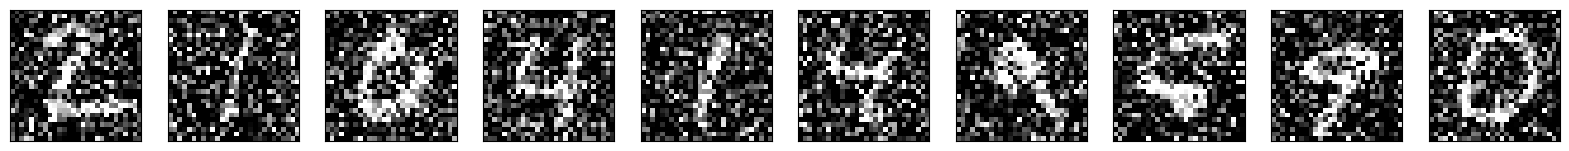

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_img = keras.Input(shape=(28, 28, 1))

#Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

#Decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compiling autoencoder model
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 131s 278ms/step - loss: 0.2639 - val_loss: 0.1188
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 128s 272ms/step - loss: 0.1165 - val_loss: 0.1086
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 146s 280ms/step - loss: 0.1086 - val_loss: 0.1052
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 130s 277ms/step - loss: 0.1056 - val_loss: 0.1030
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 292ms/step - loss: 0.1036 - val_loss: 0.1017
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 291ms/step - loss: 0.1021 - val_loss: 0.1007
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 287ms/step - loss: 0.1012 - val_loss: 0.0996
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 131s 280ms/step - loss: 0.1002 - val_loss: 0.0989
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 281ms/step - loss: 0.0994 - val_loss: 0.0983
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 147s 292ms/step - loss: 0.0988 - val_loss: 0.0983


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step


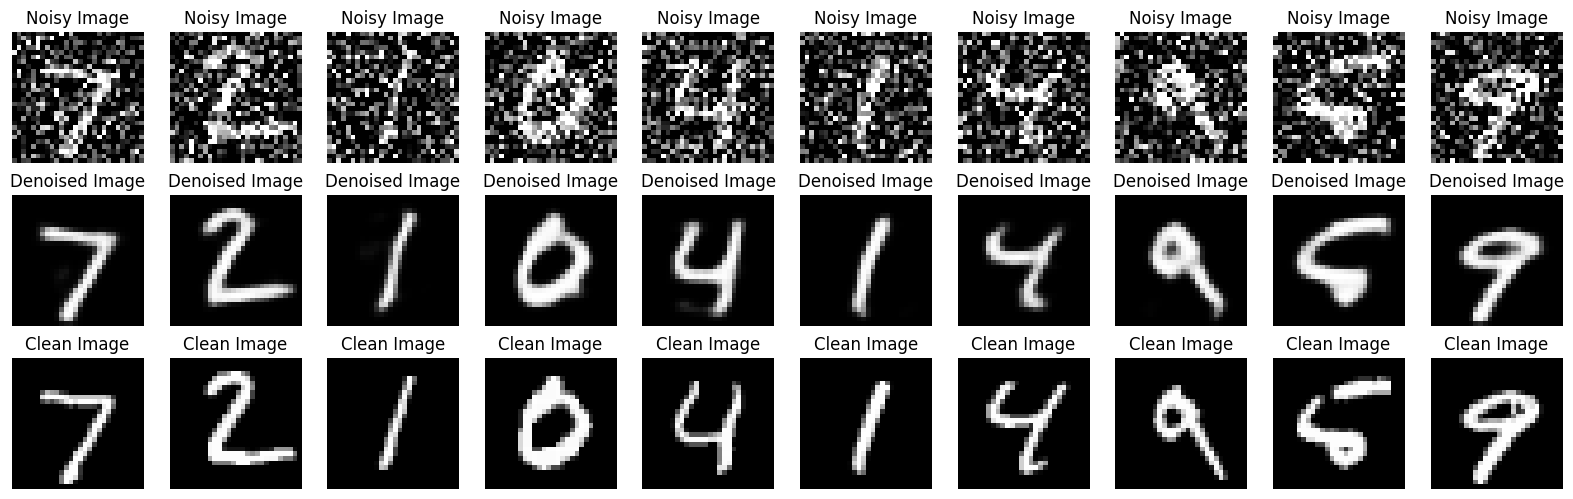

In [ ]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy)

# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Plot noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        # Plot denoised images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        # Plot clean images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
        plt.title("Clean Image")
        plt.axis('off')
    plt.show()

# Display the first 10 images
plot_images(x_test_noisy, denoised_images, x_test, n=10)